# Regression models 

This script introduces the investigated regression models to map the feature data to CO2 emissions.

Models:
    - LASSO
    
At each training section (for each individual sector and for all sectors together) it can be chosen if training and testing plots should be shown (verbose variable in RunModels) and if a Pearson Correlation heat map should be shown.

The regression is done for different input and output parameters. It is divided in the three sectors economy, mobility, and energy and household. Also the regression of all features to the total amount of CO2 emissions is tested.

There are different plots that compare the models within the sections.

## Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import KFold


plt.rcParams.update({'font.size':16})


Using TensorFlow backend.


# Read database

In [2]:
# Import whole database
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)

## Read feature data of sectors from database

### Economy

In [3]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1) #, join="inner"

#convert index in datetime format
X_eco_raw['date'] = X_eco_raw.index
X_eco_raw.date = pd.to_datetime(X_eco_raw.date).dt.to_period('m')
X_eco_raw.index = X_eco_raw.date
X_eco_raw = X_eco_raw.drop('date', axis=1)

#training period: 2011-01 - 2020-05
X_eco_raw = X_eco_raw.loc['2011-01':'2020-06']

X_eco_raw = X_eco_raw.dropna(axis=1)


### Mobility

In [4]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1)
            
#convert index in datetime format
X_mob_raw['date'] = X_mob_raw.index
X_mob_raw.date = pd.to_datetime(X_mob_raw.date).dt.to_period('m')
X_mob_raw.index = X_mob_raw.date
X_mob_raw = X_mob_raw.drop('date', axis=1)
X_mob_raw.loc['2011-05']
#X_mob_raw.head()

#training period: 2011-01 - 2020-05
X_mob_raw = X_mob_raw.loc['2011-01':'2020-06']
X_mob_raw = X_mob_raw.dropna(axis=1)

## Energy and households

In [5]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1)

#convert index in datetime format            
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)
#X_eh_raw.head()

#training period: 2011-01 - 2020-05

X_eh_raw = X_eh_raw.loc['2011-01':'2020-06']
X_eh_raw = X_eh_raw.dropna(axis=1)

## Read CO2 emission data from database

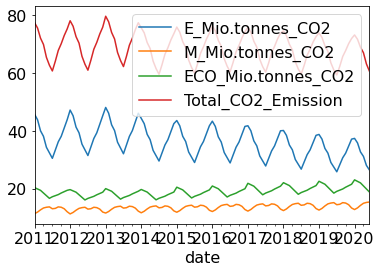

In [6]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

#convert index in datetime format
Y_raw['date'] = Y_raw.index
Y_raw.date = pd.to_datetime(Y_raw.date).dt.to_period('m')
Y_raw.index = Y_raw.date
Y_raw = Y_raw.drop('date', axis=1)

Y_raw = Y_raw.loc['2011-01':'2020-06']

# plot CO2 emissions
Y_raw.plot()

# Correlation function
Function to generate a person correlation heatmap and visualize the correlation of the features to each other and to the CO2 emissions.
Depending on the number of features this map can have a very bad overview.

In [7]:
def PlotPearsonCorrMap(X,y, title='Pearson correlation'):
    df = pd.concat([y, X], axis=1)
    plt.figure(figsize=(24,20))
    cor = df.corr(method='pearson')
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.title(title)
    plt.show()

# Model Functions
Functions of the models are shown here. 

Return of each function:
    - best working estimator based on the optimization parameters
    - scaler if needed

## Model 4: LASSO

In [8]:
def my_LASSO(x, y, x_future, alphas, verbose):
    
    
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    cval = KFold(n_splits=10)
    lsso = Lasso()

    tuned_parameters = [{'alpha': alphas}]

    search = GridSearchCV(lsso, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x_scaled, y)
    
    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x_scaled)
    
    
    df_results = pd.DataFrame(search.cv_results_)
    
    #mean scores of GridSearchCV 
    
    best_param = search.best_params_['alpha']
    ind = np.argmin(abs(alphas-best_param))
    
    mean_train_score = search.cv_results_['mean_train_score'][ind]
    mean_test_score = search.cv_results_['mean_test_score'][ind]
    
    mean_score = [-mean_train_score, -mean_test_score]
    
  
#plots and output
    if verbose:
        
        print('################################################################################')
        print('LASSO Regression')
        print('################################################################################')

        print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
        print(search.best_params_)

        plt.figure()
        plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
        plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
        plt.legend()
        plt.xticks(alphas)
        plt.xlabel("alpha")
        plt.ylabel("CV result score")
        plt.title("Grid search results for alpha")




        print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
        print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

        ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')


        x_future_scaled = scaler.transform(x_future)
        y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)

        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')
    
        plt.show()
    else:
        plt.close()
        
    return best_estimator, scaler, mean_score

## Function to run all models based on input features X and ground truth y

Runs five above introduces models.
Training time period and testing time period can be adjusted.

Return: 3 dataframes:
    - df_result: r2 and rmse of each model 
    - df_result_arr: estimated CO2 emission of each model for the test period
    - df_result_arr_train: estimated CO2 emission of each model for the train period

In [9]:
def RunModels(X, y, verbose=False):
    
#prepare features and ground truth

    #train data
    X_train = X[(X.index.year <= 2019)]
    y_train = y[(y.index.year <= 2019)]
    y_train = y_train[(y_train.index >= X.index.min())]
    
    #test data
    #overlap with train time span because the test set is not really a test set 
    #but represents the time during Corona and the two years before
    X_test = X[(X.index.year > 2017)]
    X_test = X_test[(X_test.index.year <= 2020)]

    y_test = y[(y.index.year > 2017)]
    y_test = y_test[(y_test.index <= X_test.index.max())]
    
#dataframe for numeric results
    arr_zeros = np.zeros((5,))
    arr_zeros[:] = np.nan
    df_result = pd.DataFrame({'r2_train':arr_zeros, 'rmse_train':arr_zeros}, index=['LR', 'NN', 'PLSR', 'LASSO', 'Ridge'])
    df_result_mean_score = pd.DataFrame({'mse_mean_train':arr_zeros, 'mse_mean_test':arr_zeros}, index=['LR', 'NN', 'PLSR', 'LASSO', 'Ridge'])
    
    arr_zeros = np.zeros((y_test.shape[0],))
    arr_zeros[:] = np.nan
    df_result_arr = pd.DataFrame({'LASSO':arr_zeros, 'OekoInstitute': np.array(y_test.values).flatten()}, index=y_test.index)
    
    arr_zeros = np.zeros((y_train.shape[0],))
    arr_zeros[:] = np.nan
    df_result_arr_train = pd.DataFrame({'LASSO':arr_zeros, 'OekoInstitute': np.array(y_train.values).flatten()}, index=y_train.index)

    
#Models
    
    
    ######
    #LASSO
    alphas = np.linspace(0,0.2,50)

    LASSO, LASSO_SCALER, mean_score_Lasso = my_LASSO(X_train, y_train, X_test, alphas, verbose)
    
    #estimate CO2 emissions based on input and save it in dataframe
    X_train_scaled = LASSO_SCALER.transform(X_train)
    X_test_scaled = LASSO_SCALER.transform(X_test)

    y_pred_train_LASSO = LASSO.predict(X_train_scaled)
    y_pred_test_LASSO = LASSO.predict(X_test_scaled)

    df_result['r2_train']['LASSO'] = r2_score(y_train,y_pred_train_LASSO)
    df_result['rmse_train']['LASSO'] = np.sqrt(mean_squared_error(y_train,y_pred_train_LASSO))
    df_result_mean_score['mse_mean_train']['LASSO'] = mean_score_Lasso[0]
    df_result_mean_score['mse_mean_test']['LASSO'] = mean_score_Lasso[1]
    
    df_result_arr['LASSO'] = y_pred_test_LASSO
    df_result_arr_train['LASSO'] = y_pred_train_LASSO
    
   

    print('Training done!')
    
    return df_result, df_result_arr, df_result_arr_train, df_result_mean_score

# Train the models
X: feature matrix \
y: CO2 Emissions

# merge Economy with Energy and Household

In [10]:
X = X_eh_raw #pd.concat([X_eco_raw,X_eh_raw], axis=1)  
X = X.drop('Deutschland', axis=1)
for col in X:
    if 'CO2' not in col:
        X = X.drop(col,axis=1)

y = pd.DataFrame(Y_raw['ECO_Mio.tonnes_CO2'] + Y_raw['E_Mio.tonnes_CO2'])

df_result_ECO_EH, df_result_arr_ECO_EH, df_result_arr_train_ECO_EH, df_result_mean_score_ECO_EH = RunModels(X, y, verbose=False)
df_result_mean_score_ECO_EH


Training done!


,mse_mean_train,mse_mean_test
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,11.137921,17.662212
Ridge,NaN,NaN


,r2_train,rmse_train
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,0.66536,3.375328
Ridge,NaN,NaN


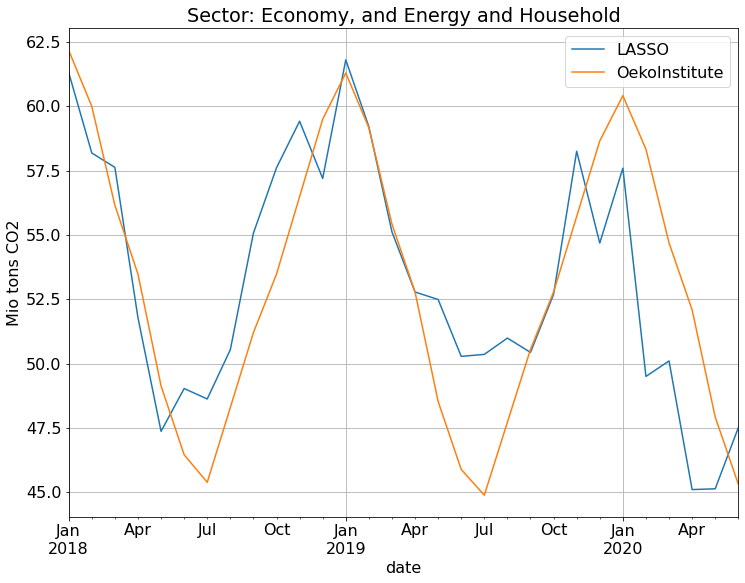

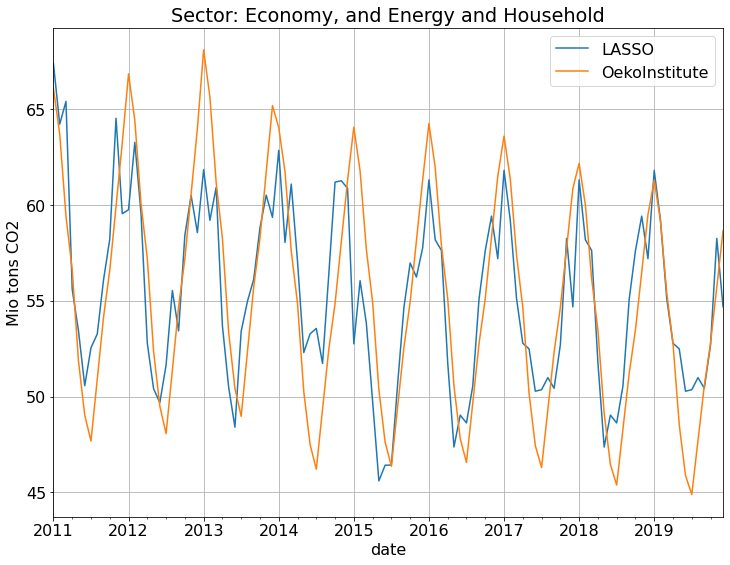

In [11]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_ECO_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy, and Energy and Household')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_ECO_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy, and Energy and Household')

#show the r2 and rmse of the training set
df_result_ECO_EH

## Mobility

In [12]:
X = X_mob_raw
y = Y_raw[['M_Mio.tonnes_CO2']]

In [13]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation sector Mobility')

In [14]:
df_result_M, df_result_arr_M, df_result_arr_train_M, df_result_mean_score_M = RunModels(X, y, verbose=False)

Training done!


In [21]:
df_result_M

,r2_train,rmse_train
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,0.832593,0.378713
Ridge,NaN,NaN


,r2_train,rmse_train
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,0.832593,0.378713
Ridge,NaN,NaN


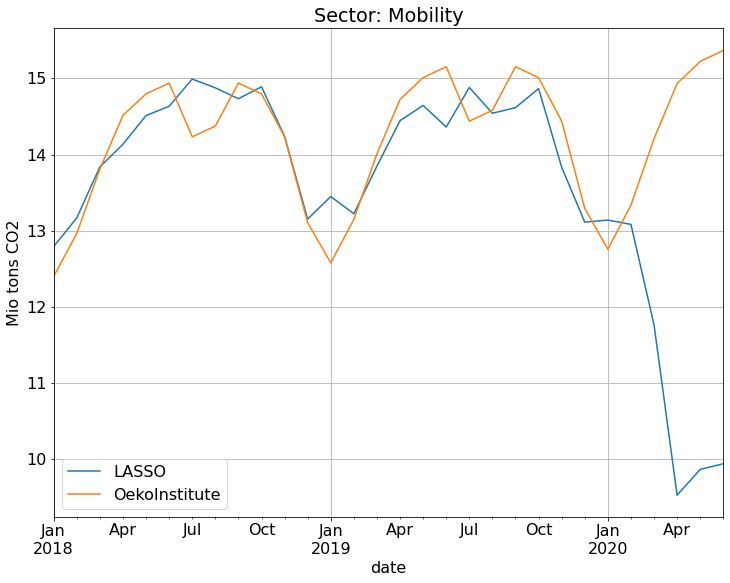

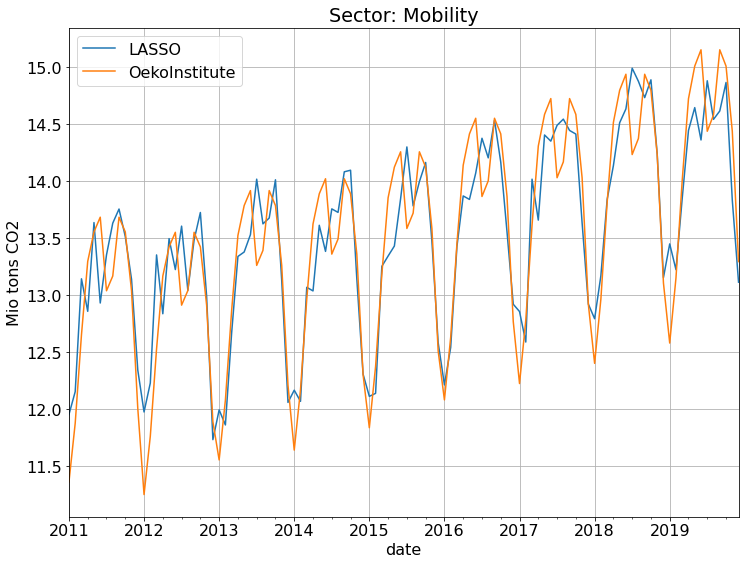

In [16]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')

#show the r2 and rmse of the training set
df_result_M

# All sectors

In [17]:
X = pd.concat([X_eh_raw, X_mob_raw], axis=1)
y = Y_raw[['Total_CO2_Emission']]
df = pd.concat([X,y], axis=1).dropna(axis=0)
y = df[['Total_CO2_Emission']]
X = df.drop('Total_CO2_Emission', axis=1)

In [18]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation all sectors')

In [19]:
df_result_all,df_result_arr_all,df_result_arr_train_all, df_result_mean_score_all = RunModels(X, y, verbose=False)
df_result_mean_score_all

Training done!


,mse_mean_train,mse_mean_test
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,1.631494,2.431137
Ridge,NaN,NaN


,r2_train,rmse_train
LR,NaN,NaN
NN,NaN,NaN
PLSR,NaN,NaN
LASSO,0.937131,1.289135
Ridge,NaN,NaN


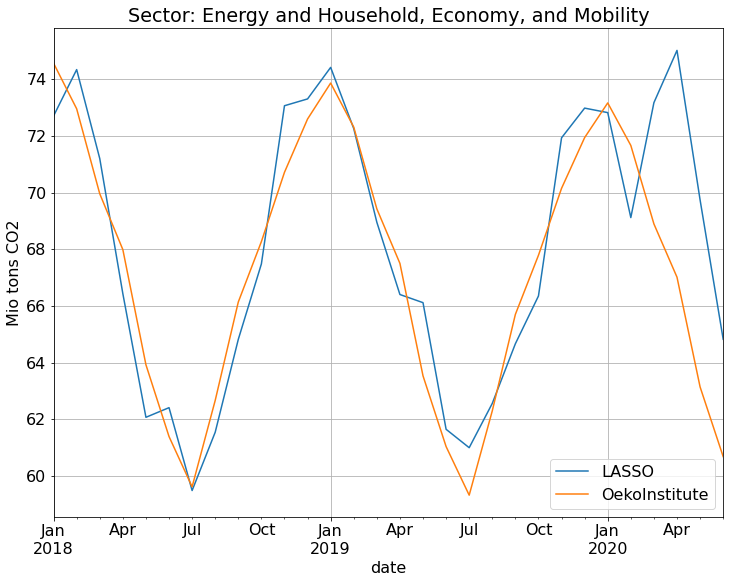

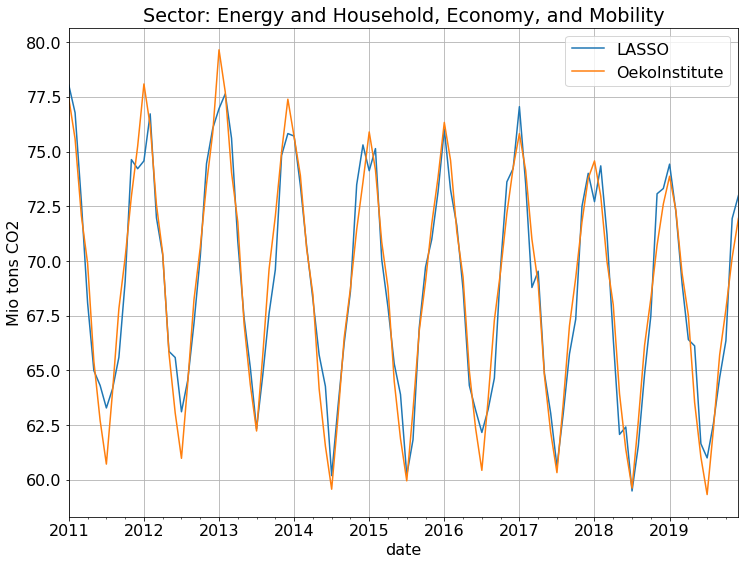

In [20]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_all.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household, Economy, and Mobility')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_all.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household, Economy, and Mobility')

#show the r2 and rmse of the training set
df_result_all